# Table of contents
1. Import libraries & data
2. Prep data for time series analysis
3. Decomposition
4. Test for stationarity
5. Stationarize data

# 1. Import libraries & data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'InsertHereQuandlAPIKey'

In [3]:
# Import data set >>> Gross Domestic Product Per Capita for Central Europe and the Baltics
data = quandl.get('FRED/NYGDPPCAPCDCEB')

In [4]:
# Check output
data.head()

,Value
Date,
1990-01-01,2314.688781
1991-01-01,2197.245977
1992-01-01,2360.946348
1993-01-01,2491.012300
1994-01-01,2826.235767


In [5]:
data.shape

(31, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

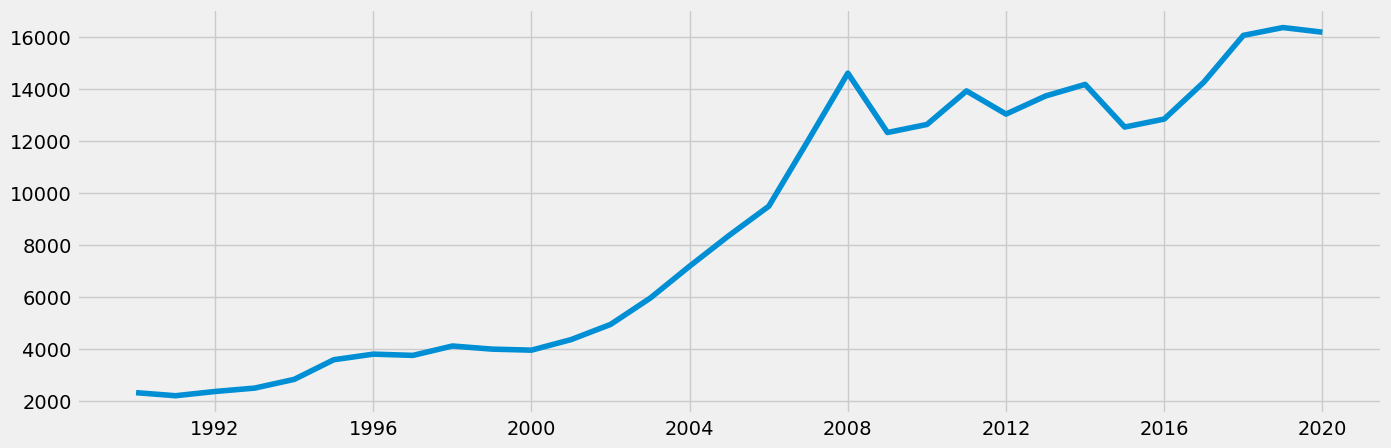

In [8]:
# Plot data using matplotlib
plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

# 2. Prep data for time series analysis

In [10]:
# Subset data set to exclude data before 2000
# Explanation >>> Economic conditions have changed in the new millennium. Older data wouldn't be relevant

# First reset index

data_2 = data.reset_index()

In [11]:
# Check output
data_2.head()

,Date,Value
0,1990-01-01,2314.688781
1,1991-01-01,2197.245977
2,1992-01-01,2360.946348
3,1993-01-01,2491.012300
4,1994-01-01,2826.235767


In [12]:
# Create subset >>> only data from 2020 on
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01')]

In [13]:
# Check output
data_sub.shape

(21, 2)

In [14]:
data_sub.head()

,Date,Value
10,2000-01-01,3948.762471
11,2001-01-01,4354.432440
12,2002-01-01,4938.544567
13,2003-01-01,5946.456625
14,2004-01-01,7176.701402


In [15]:
# Set "Date" column as index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True)

data_sub.head()

,Value
datetime,
2000-01-01,3948.762471
2001-01-01,4354.432440
2002-01-01,4938.544567
2003-01-01,5946.456625
2004-01-01,7176.701402


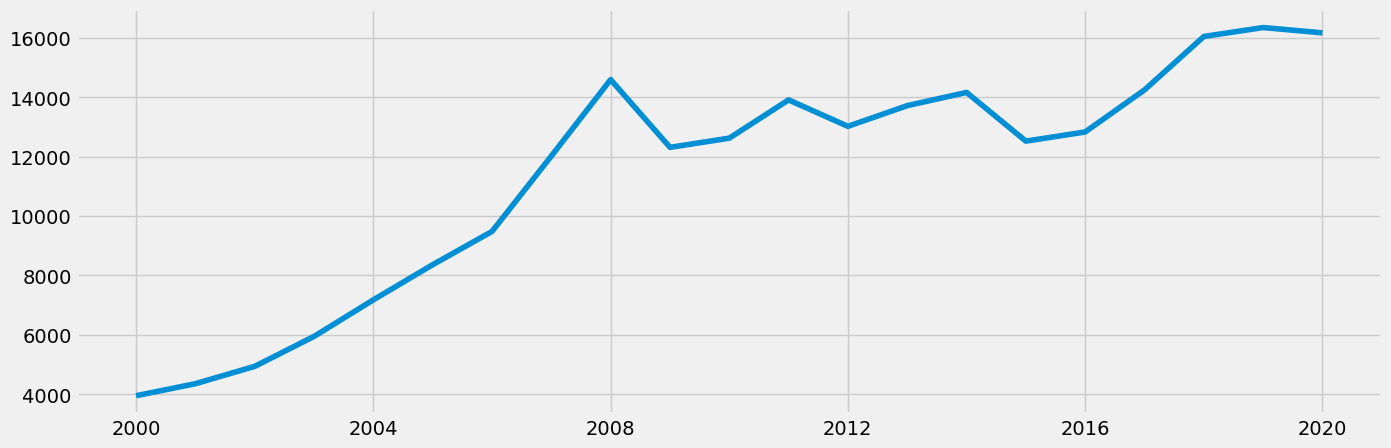

In [17]:
# Plot the data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [19]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()
# No duplicates

0

# 3. Decomposition

In [20]:
# Decompose time series using additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
# Define size for charts

from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

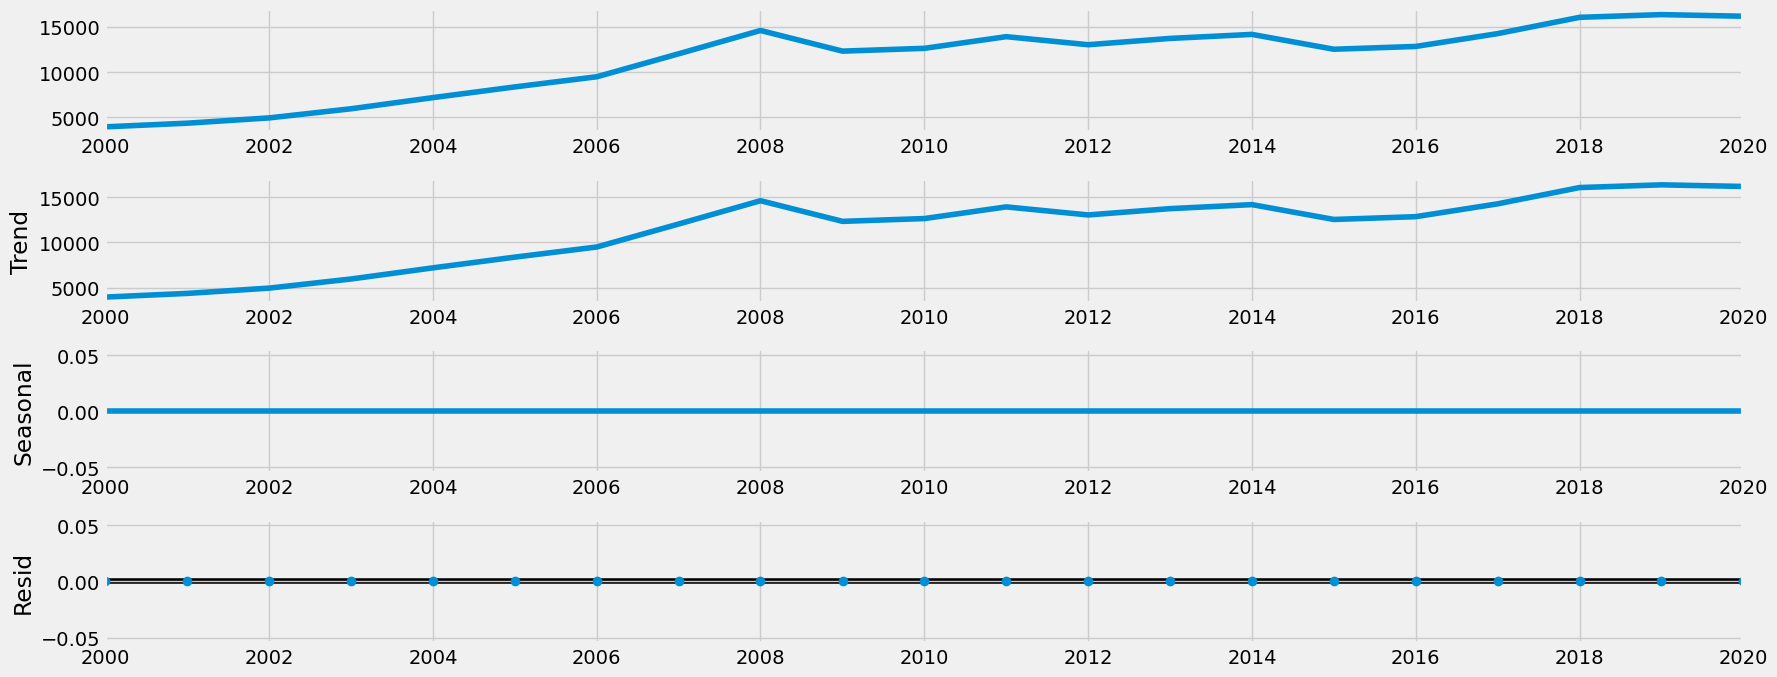

In [22]:
# Plot charts showing separate components

decomposition.plot()
plt.show()

In [24]:
# Comment

# The first chart is the "level", i.e. the original chart. It's there for comparison
# The second chart isolates the time series' underlying trend. Since we are working with smoothed data (no noise), it's the same as the level
# The trend gradually and steadily goes up, with minor dips over the years. We therefore see a dominant trend upwards
# The third line is seasonality, which in this case is flat meaning there isn't any
# The last chart is called "residual" and shows the noise. Since it's flat it means that there is no noise, i.e. no unexplained trends

# 4. Test for stationarity

In [25]:
# Run Dickey-Fuller test to check stationarity

# First import dedicated function
from statsmodels.tsa.stattools import adfuller

# Then define function & set up test
def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Finally apply test using the function on time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.913354
p-value                         0.325805
Number of Lags Used             2.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


In [30]:
# p-value is 0.3 something and therefore not significant (i.e. it's larger than 0.05)
# "Test Statistic" is larger than Critical Value >>> we therefore can’t reject null hypothesis
# Data is non stationary

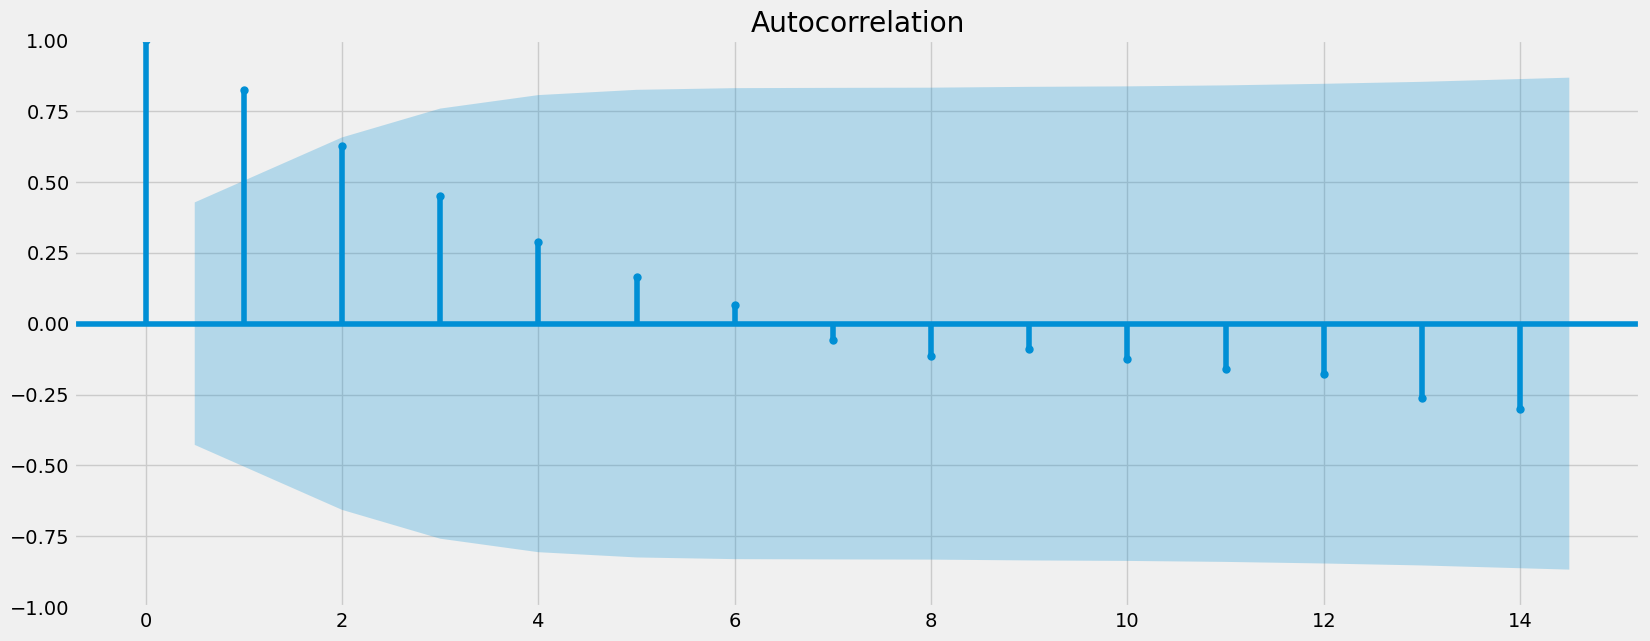

In [31]:
# Test again for stationarity by plotting out autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

In [32]:
# Some lags (blue lines) lie beyond the confidence interval (light blue area)
# This is an indication that data is non stationary (although not heavily)

In [33]:
# Both Dickey-Fuller test & autocorrelations check indicate that data is non stationary
# Data needs to be stationarized before moving forward

# 5. Stationarize data

In [35]:
# Apply differencing method to stationarize data
data_diff = data_sub - data_sub.shift(1)

In [36]:
# Remove nulls to be able to conduct Dickey-Fuller test
data_diff.dropna(inplace = True)

In [37]:
# Check output
data_diff.head()

,Value
datetime,
2001-01-01,405.669970
2002-01-01,584.112127
2003-01-01,1007.912057
2004-01-01,1230.244777
2005-01-01,1186.279352


In [38]:
data_diff.columns

Index(['Value'], dtype='object')

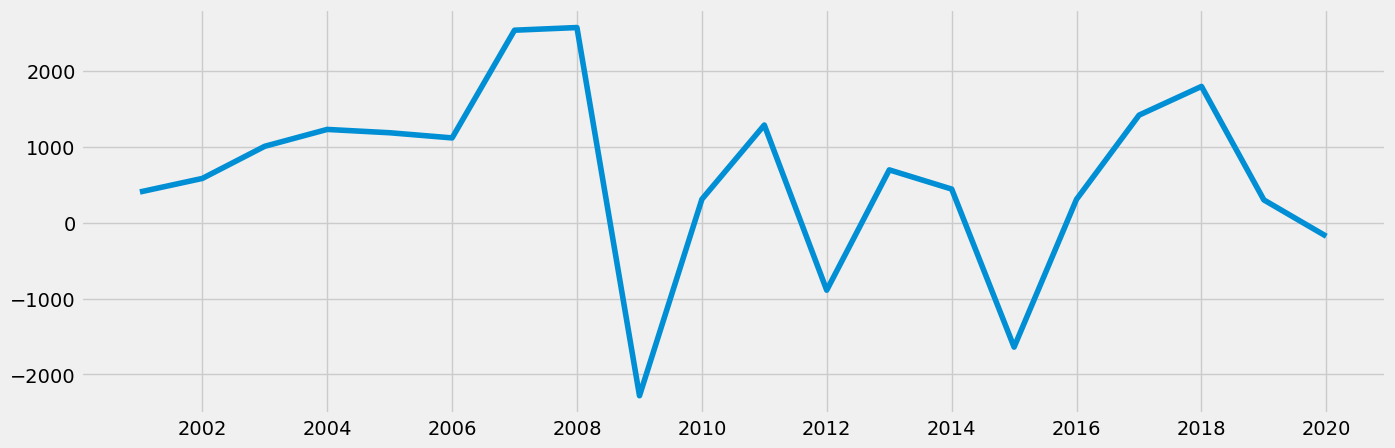

In [39]:
# Check what differencing did to time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [40]:
# Differencing did its work >>> got rid of data's trend

In [41]:
# Run again Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -59.864588
p-value                         0.000000
Number of Lags Used             8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


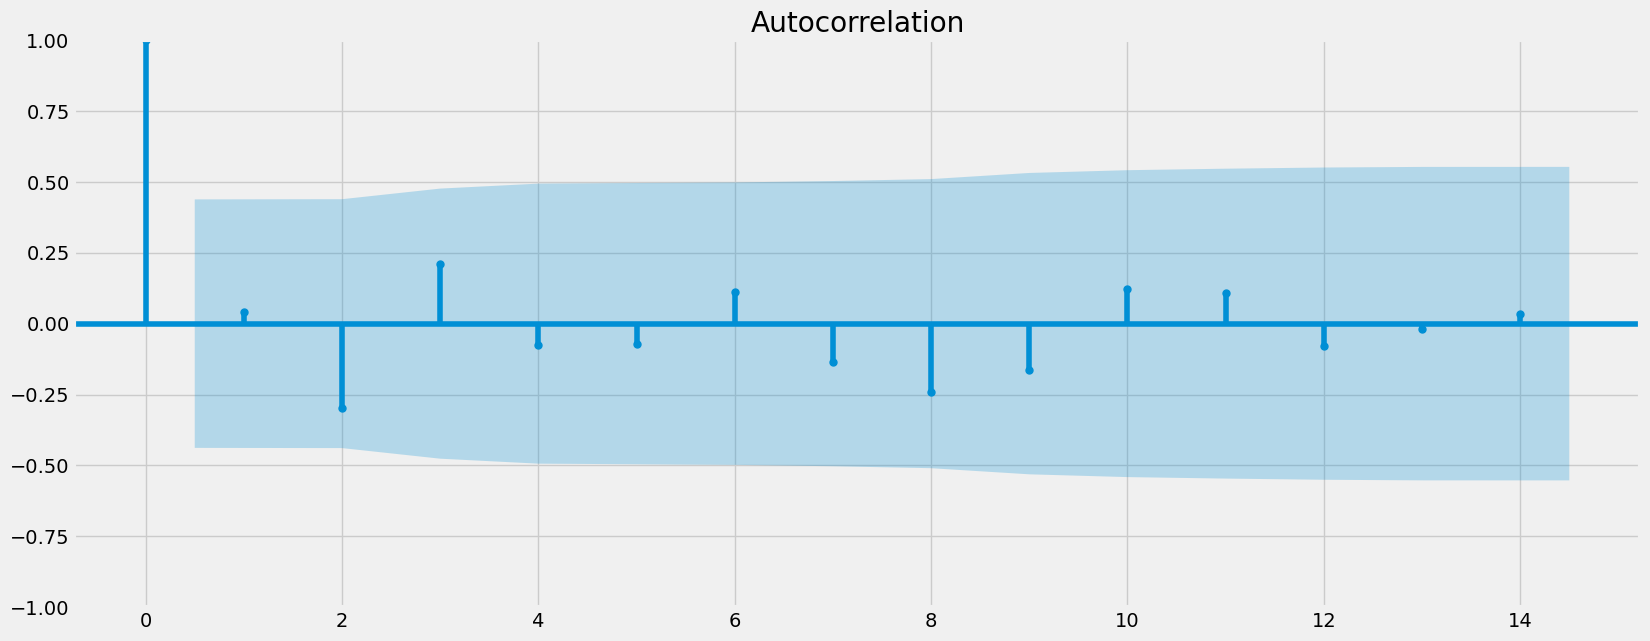

In [42]:
# Run again autocorrelations check
plot_acf(data_diff)
plt.show()

In [43]:
# p-value is now smaller than than 0.05
# "Test Statistic" is much smaller than Critical Value >>> we can reject null hypothesis
# More lags in the autocorrelations check lie within the confidence interval
# Data is now stationary and can be used for time series forecasting